In [10]:
import sys,os
import configargparse

import torch
import numpy as np

from srns import *
import util

_MODEL_PATH = './logs/032315face_seg_2000_depth_ckpt/checkpoints/epoch_0010_iter_040000.pth'

_NUM_INSTANCES = 1494

model = SRNsModel(num_instances=_NUM_INSTANCES,
                  latent_dim=256,
                  fit_single_srn=False,
                  use_unet_renderer=False,
                  tracing_steps=10,
                  freeze_networks=True,
                  out_channels=19,
                  img_sidelength=128,
                  output_sidelength=512
                 )

util.custom_load(model, path=_MODEL_PATH, discriminator=None,
                 overwrite_embeddings=False)

model.eval()
model.cuda()

Number of parameters:
382464


SRNsModel(
  (latent_codes): Embedding(1494, 256)
  (hyper_phi): HyperFC(
    (layers): ModuleList(
      (0): NewCls(
        (hyper_linear): HyperLinear(
          (hypo_params): FCBlock(
            (net): Sequential(
              (0): FCLayer(
                (net): Sequential(
                  (0): Linear(in_features=256, out_features=256, bias=True)
                  (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                  (2): ReLU(inplace=True)
                )
              )
              (1): FCLayer(
                (net): Sequential(
                  (0): Linear(in_features=256, out_features=256, bias=True)
                  (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                  (2): ReLU(inplace=True)
                )
              )
              (2): Linear(in_features=256, out_features=1024, bias=True)
            )
          )
        )
        (norm_nl): Sequential(
          (0): LayerNorm((256,), eps=1e-05, elementwise

In [2]:
import dataio
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter

import cv2
import imageio

_OUTPUT_DIR = './logs/latent_interpolation/032315face_seg_2000_depth_ckpt'
_MODE = 'sphere'
_R = 1.2

_NUM_INSTANCES=1
_NUM_OBSERVATIONS=24

output_dir = os.path.join(_OUTPUT_DIR, _MODE)

dataset = dataio.FaceRandomPoseDataset(
    num_instances=_NUM_INSTANCES, num_observations=_NUM_OBSERVATIONS, sample_radius=_R, mode=_MODE)

dataset = DataLoader(dataset,
                     collate_fn=dataset.collate_fn,
                     batch_size=1,
                     shuffle=False,
                     drop_last=False)

In [14]:
src_idx = torch.Tensor([207]).squeeze().long().cuda()
trgt_idx = torch.Tensor([23]).squeeze().long().cuda()
num_interps = 8

z_src = model.get_embedding({'instance_idx': src_idx}).unsqueeze(0).repeat(num_interps, 1)
z_trgt = model.get_embedding({'instance_idx': trgt_idx}).unsqueeze(0).repeat(num_interps, 1)

print(torch.max(z_src), torch.min(z_src), z_src.shape)

interp = torch.Tensor(np.linspace(0.0, 1.0, num_interps)).squeeze().cuda().unsqueeze(1)

z_interp = z_src * (1.0 - interp) + z_trgt * interp

tensor(0.0493, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.0495, device='cuda:0', grad_fn=<MinBackward1>) torch.Size([256])


In [22]:
embedding_mean = torch.zeros(256).cuda()

for idx in range(_NUM_INSTANCES):
    embedding_mean += model.get_embedding({'instance_idx': torch.Tensor([idx]).squeeze().long().cuda()})
    
embedding_mean /= _NUM_INSTANCES
print(torch.max(embedding_mean), torch.min(embedding_mean))

tensor(0.0023, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.0027, device='cuda:0', grad_fn=<MinBackward1>)


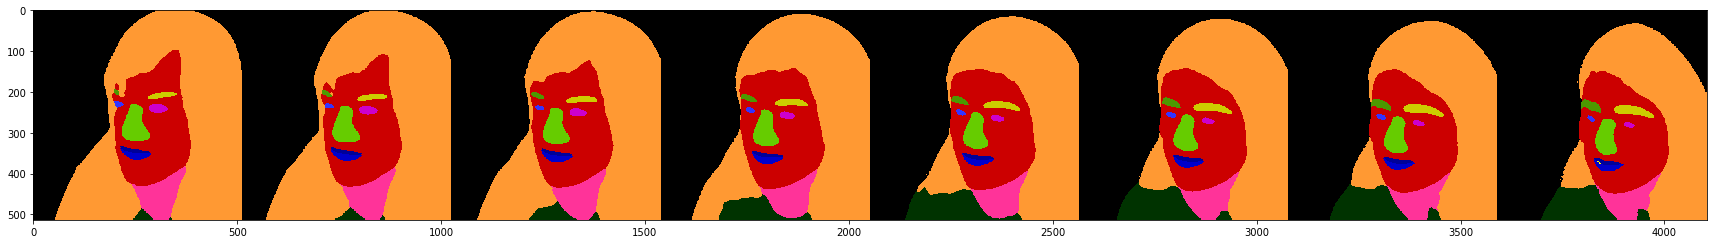

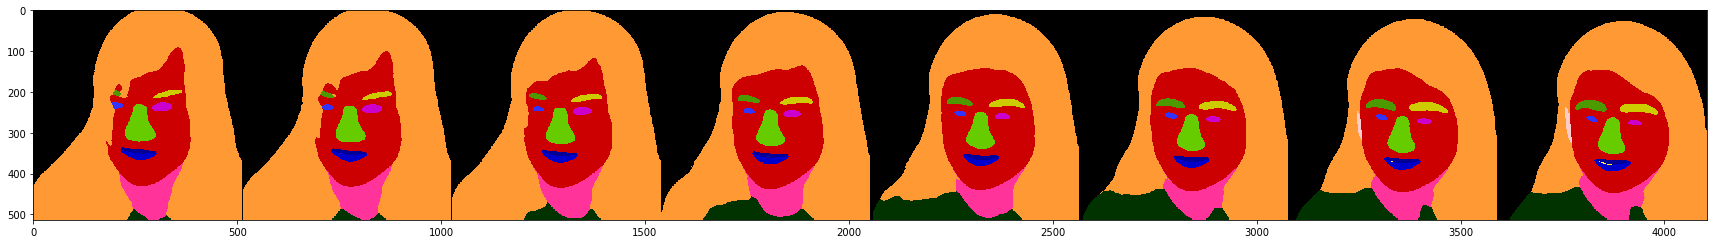

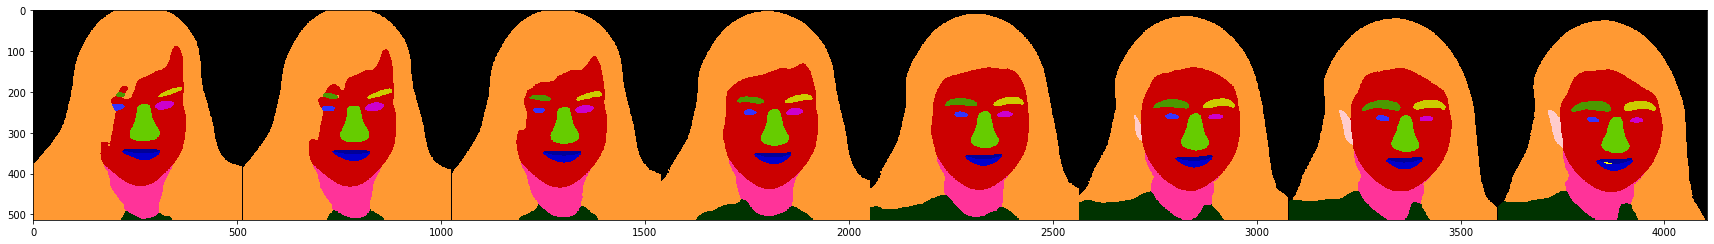

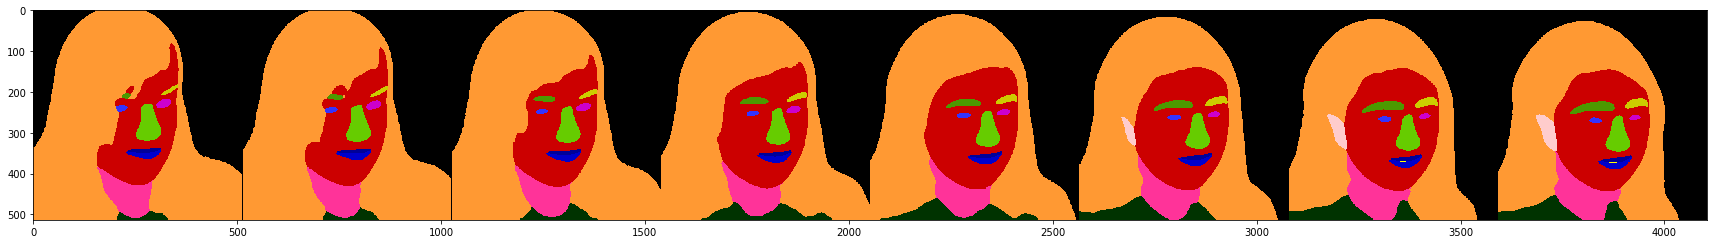

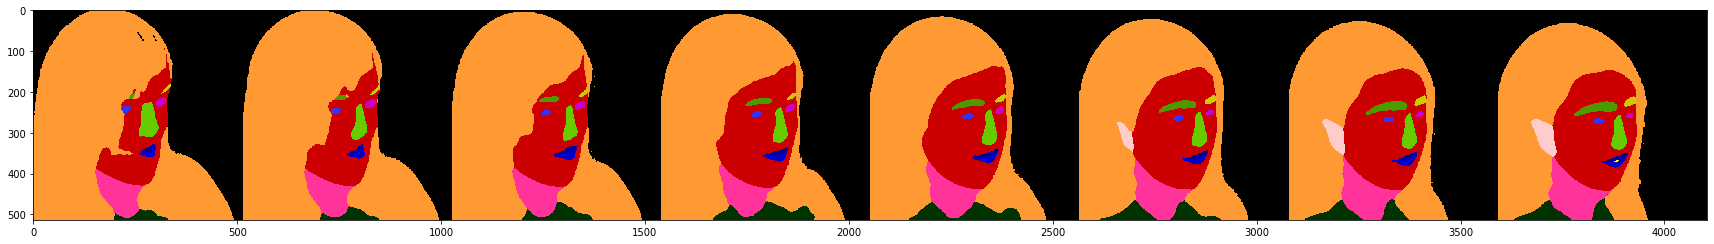

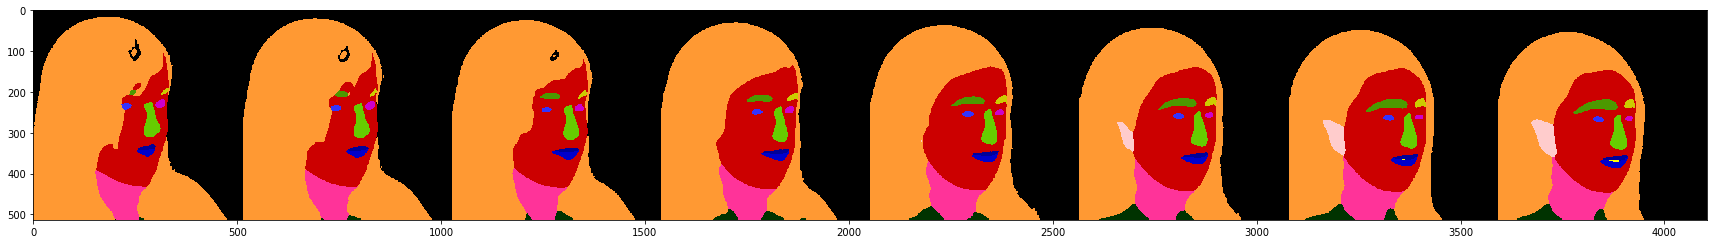

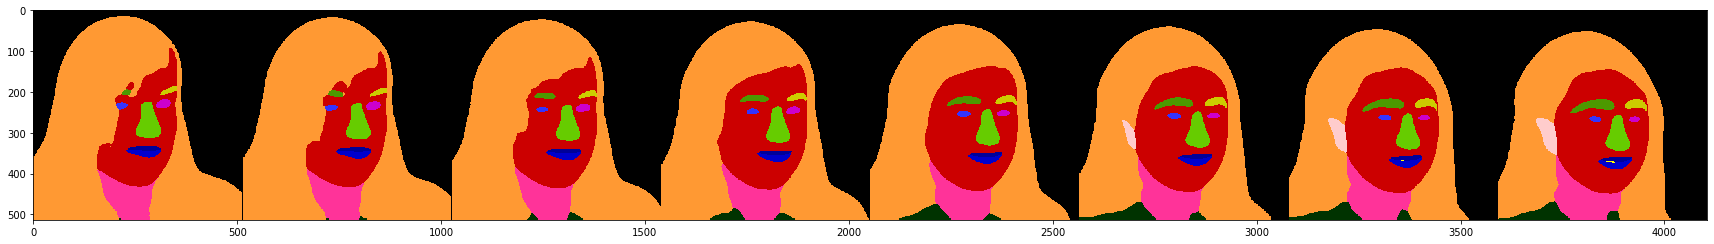

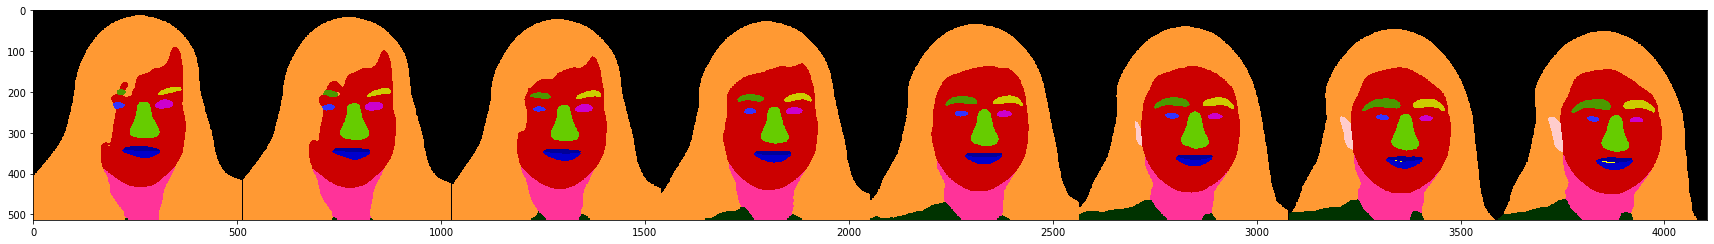

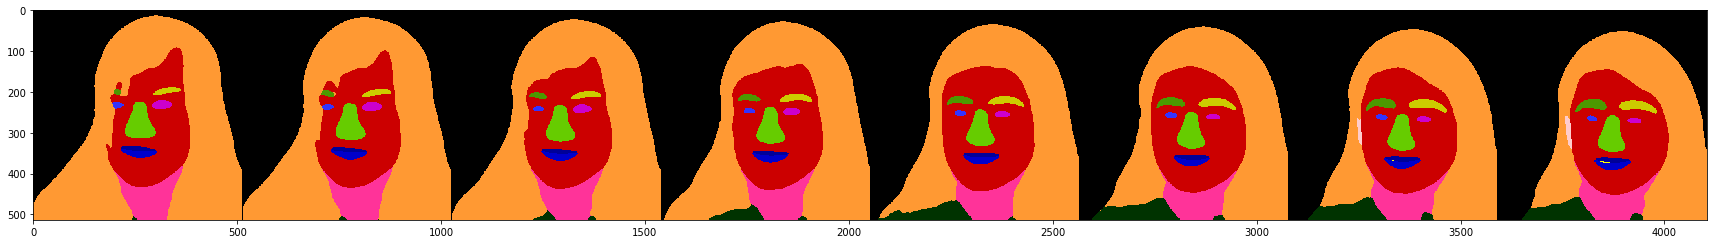

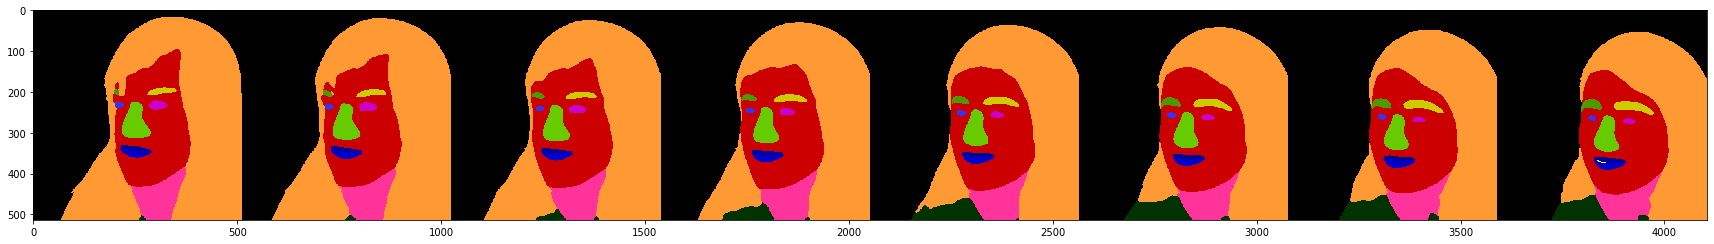

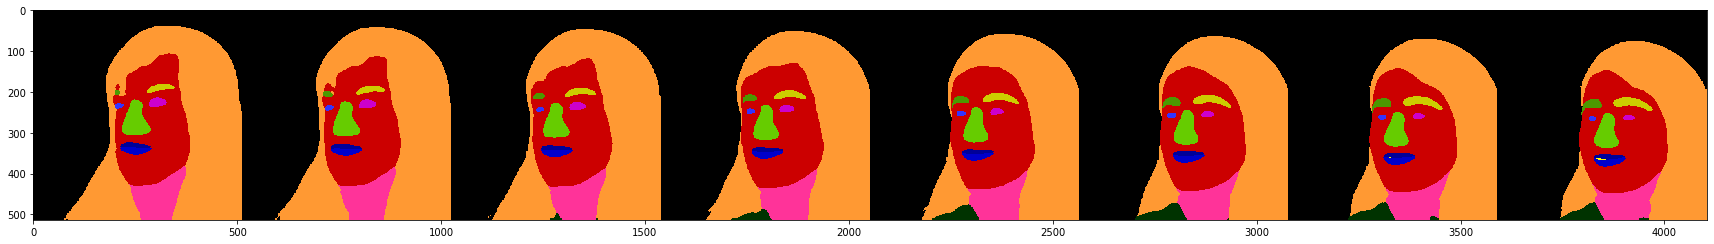

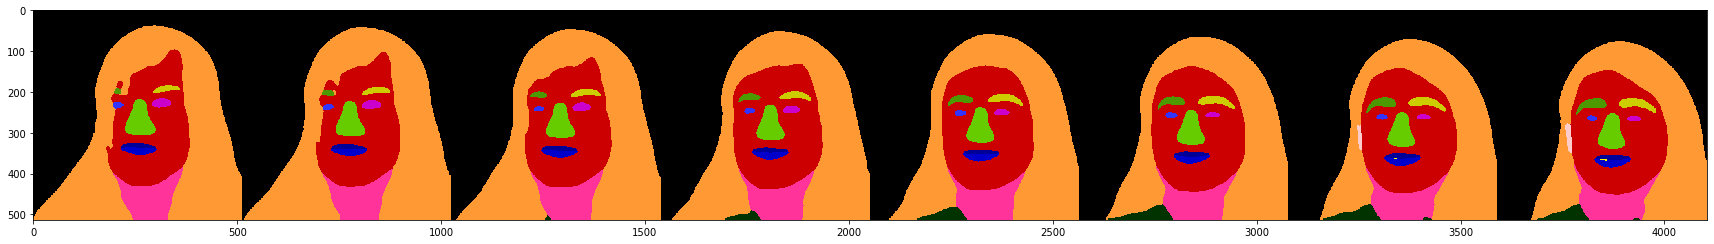

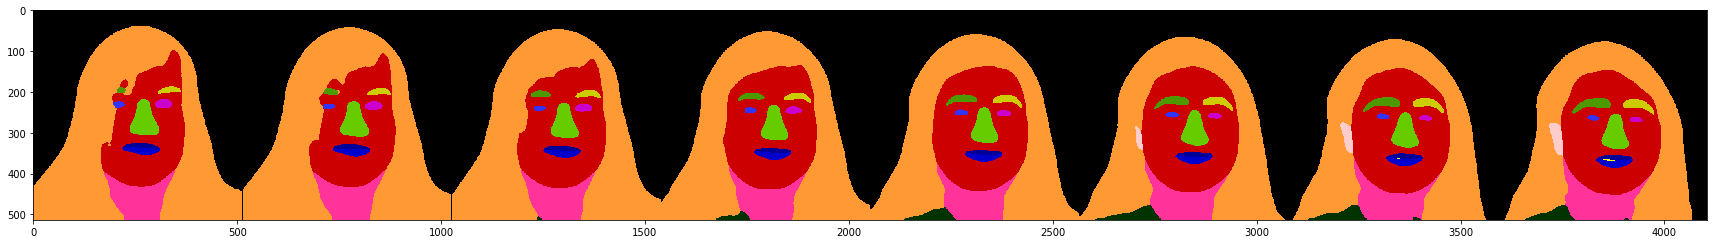

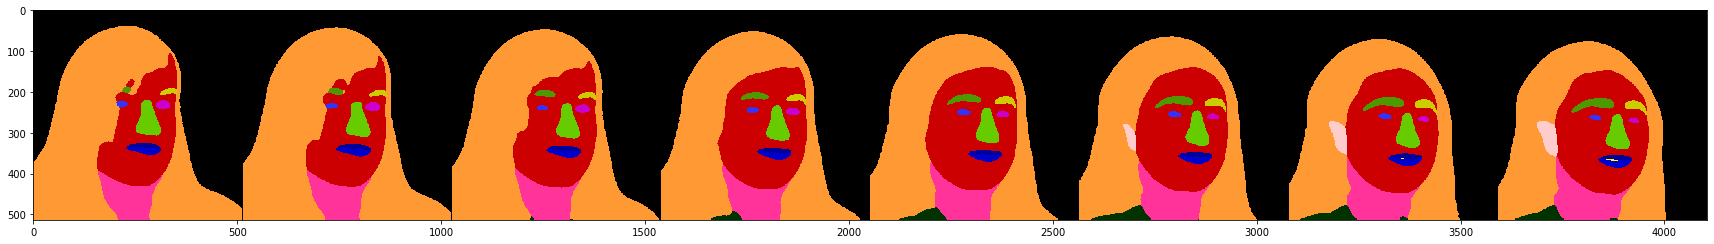

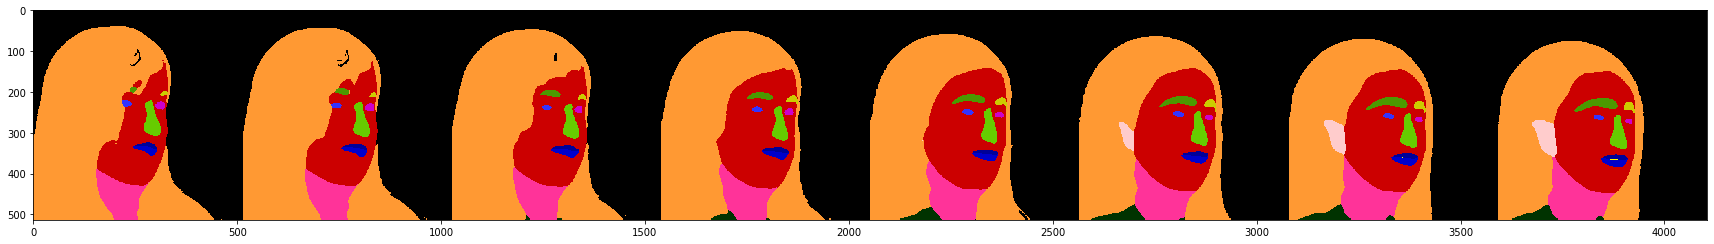

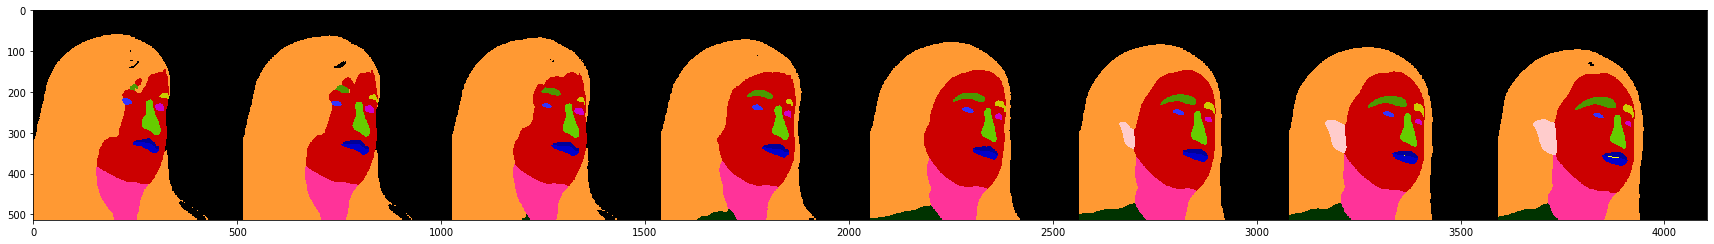

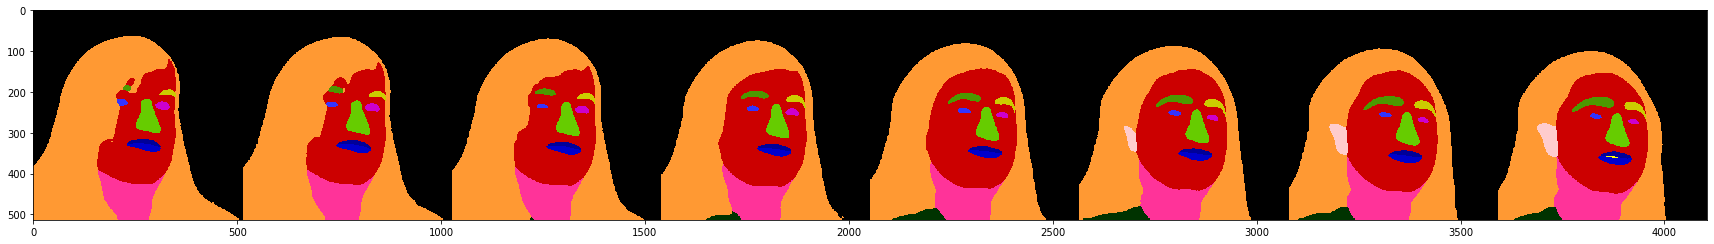

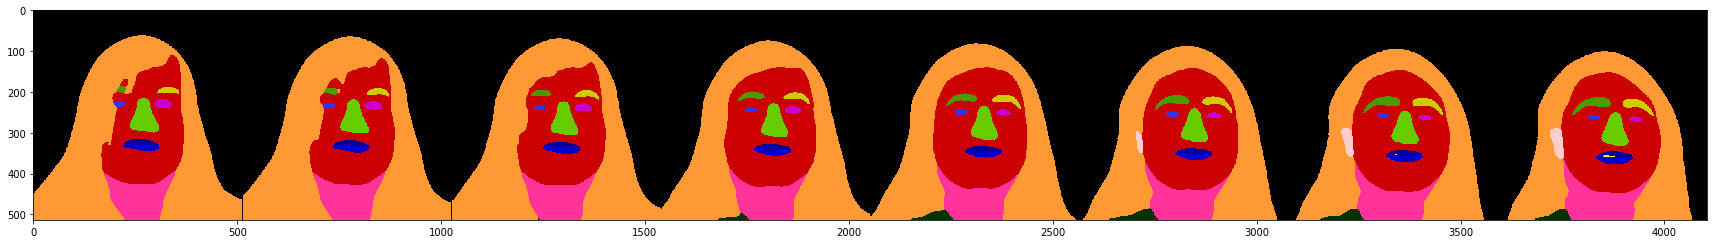

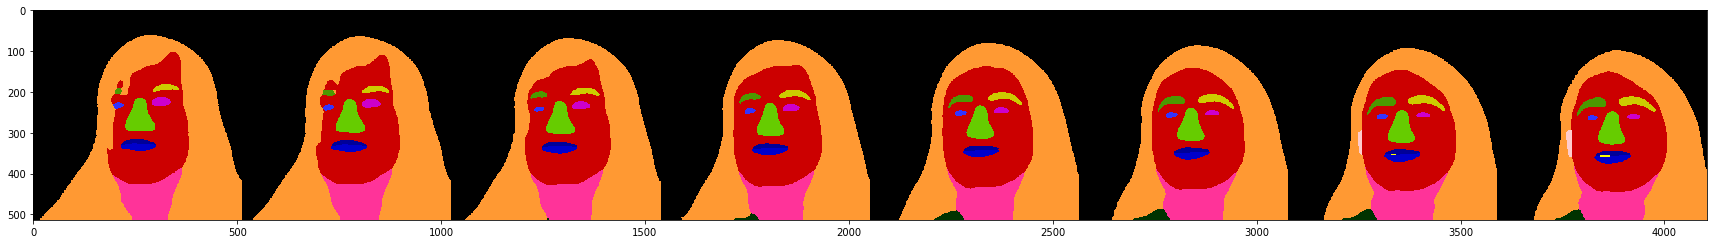

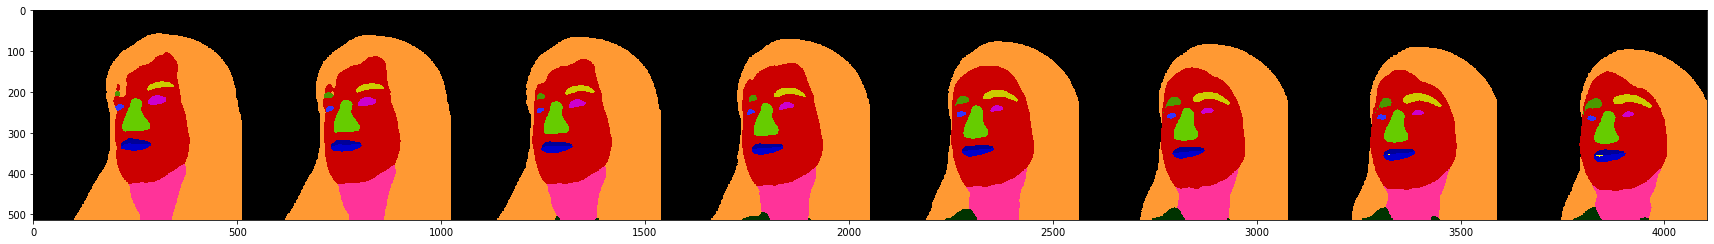

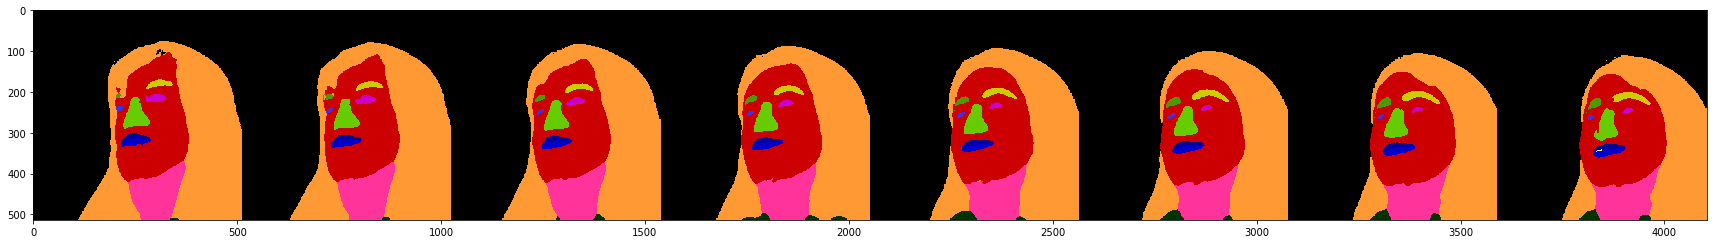

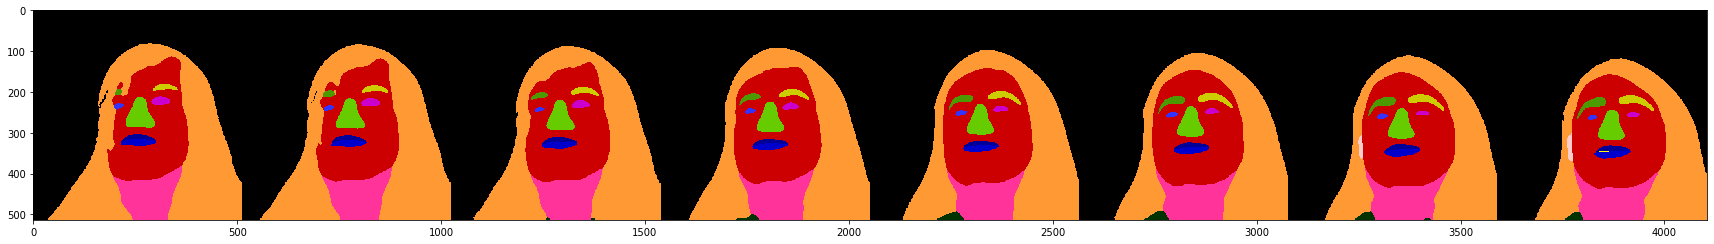

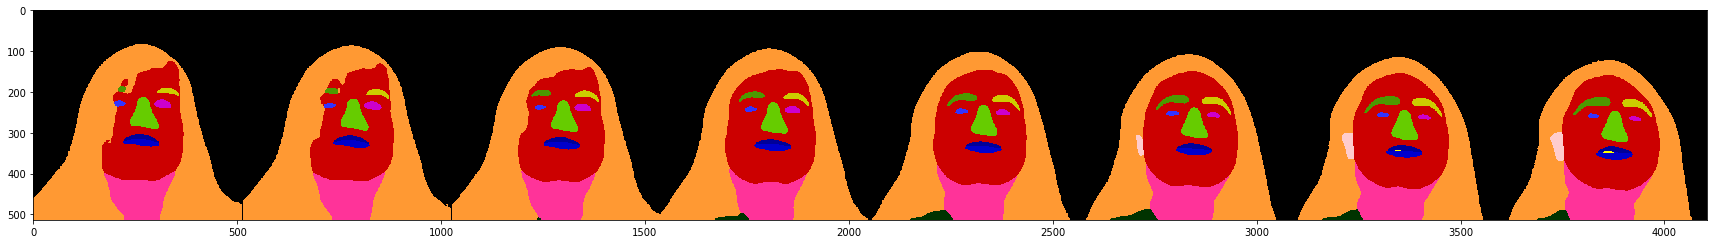

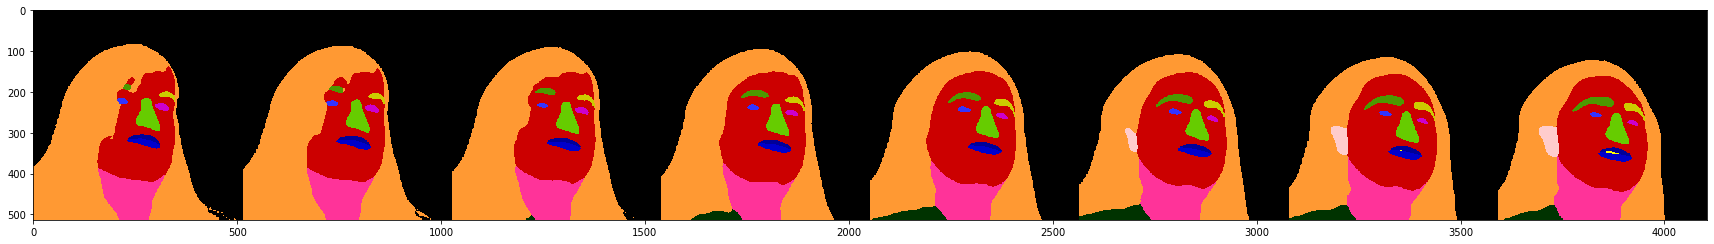

In [8]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [30, 5]

with torch.no_grad():
    instance_idx = 0
        
    for idx, model_input in enumerate(dataset):
        model_input, ground_truth = model_input
        pose = model_input['pose'].repeat(num_interps, 1, 1)
        intrinsics = model_input['intrinsics'].repeat(num_interps, 1, 1)
        uv = model_input['uv'].repeat(num_interps, 1, 1)
        
        predictions, depth_map = model(pose, z_interp, intrinsics, uv)
        
        B, _, C = predictions.shape
                
        pred = torch.argmax(predictions, dim=2, keepdim=True)
        output_img = util.lin2img(pred, colorize=True)
        output_img = make_grid(output_img, nrow=8, padding=1).permute((1, 2, 0)).cpu().numpy()
        
#         print(idx, output_img.shape, type(output_img), np.max(output_img))
        
        plt.imshow(output_img)
        plt.show()
        